# Tabular_playground_september_2021 (reduced version)

### Data Description

#### For this competition, you will predict whether a customer made a claim upon an insurance policy. The ground truth claim is binary valued, but a prediction may be any number from 0.0 to 1.0, representing the probability of a claim. The features in this dataset have been anonymized and may contain missing values.

## Libraries

In [43]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold, ShuffleSplit, cross_validate, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE

# Algoritmi
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from imblearn.pipeline import Pipeline

## Data Exploration

In [2]:
# Importo il dataset
data = pd.read_csv('Tabular_playground_data.csv')
data_reduced = data.sample(n = 1000, replace = True, random_state = 1)
pd.set_option('display.max_columns', None)

In [3]:
data_reduced.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
128037,128037,0.117930,0.003333,3842.800,0.002454,0.437800,-1.85220,261.61,31467.0,3.189700e+15,563.42,1.12090,1.342600e+07,-0.031666,3.1190,0.268540,120.6100,7.3059,1.93450,-0.56327,886.190,136650.00,2.2943,97.889,2.93560,495.960,1.542500e+12,1.399900e+11,1529600.0,-0.003138,6.4238,0.712030,53085.0,55241.0,0.000494,8.678700e+16,-1178.800,563.56,1.5934,2613.80,0.001286,1515.9000,0.484630,6.1865,43.083,-0.000155,4.3633,-0.63740,5.0088,-1.20340,-0.002755,17.07400,NaN,11.0870,119.87,0.28051,0.065822,-0.000379,-0.21670,5.2748,0.020381,0.269360,5.680400e+08,85.816,0.044977,3828.8,134.540,196.54,32.274,1.1335,0.996490,1.1610,691.230,-5.410300e+12,1.127100e+11,0.079650,7.2836,981.010,4126.0,5.01690,0.001141,4.0335,1.040500e+11,70.23900,688270.0,1238.800,5.786900e+10,7.7126,295.760,16733.0,5.9410,-0.008039,43.003,82.756,1.0634,14.0280,520.95,1.00280,9.735200e+09,2.8751,0.977240,10.2570,805860.0,-51.476,-45.775,0.045825,0.047026,0.044620,3.213900e+08,0.53509,-37.8330,1.3352,-1.5836,-13.88900,16801.0,1.0787,2.269000e+16,2671.90,0.48396,1
491755,491755,0.093184,0.258100,542.280,-0.002171,0.277570,-1.53880,3298.80,69851.0,8.191000e+13,60361.00,0.61400,1.096300e+08,0.299920,13.8910,-0.099310,60.7410,7.3907,0.99344,4.02910,213.780,-886.02,2.3016,94.312,1.22560,189.830,5.487500e+11,4.429000e+12,4718900.0,0.003034,10.7020,1.237900,666960.0,15629.0,-0.001352,6.647100e+16,161.430,658.83,NaN,141.63,0.918250,1.3897,0.086311,8.3749,23.906,0.004019,4.3673,0.74656,4.4093,-0.49052,0.433460,3.15260,2259.80,7.0814,133.82,0.37982,0.517000,NaN,-0.65149,2.1599,0.845720,0.004519,3.591800e+09,12.808,0.013700,76167.0,90.763,1360.50,11.019,1.1492,0.994780,1.5951,21.232,1.123000e+15,-1.755600e+10,1.014500,7.4033,4499.000,NaN,8.74810,0.328540,NaN,1.391200e+11,4.53590,82455.0,314.670,2.458000e+10,22.4250,9.448,10211.0,5.7530,0.490600,16603.000,132.700,1.0449,3.9341,541.46,0.99808,1.690500e+13,1.4038,NaN,20.8460,4627.3,76.024,-136.740,0.240990,0.066928,-0.000690,2.093200e+09,0.50121,-21.6220,1.5059,8.7256,4.82110,4617.2,1.1703,6.794700e+16,3766.30,0.67155,1
470924,470924,0.159500,0.475950,1423.100,0.004622,-0.001036,1.20810,657.39,685940.0,1.190000e+14,1281.80,1.41820,3.047900e+09,0.345140,17.4980,-0.102880,86.4300,6.2859,3.02500,1.61160,574.330,-1468.40,1.8014,99.321,-3.14420,34.338,5.991400e+10,-1.809300e+09,37025.0,0.969090,4.9900,0.948000,165180.0,NaN,-0.001195,5.322300e+16,13.079,1124.20,1.6454,386.29,NaN,382.6200,0.014320,7.3817,35.248,-0.004634,4.2119,0.39095,7.4614,-0.80386,0.340350,0.63577,2878.30,13.7950,129.39,0.34454,0.869150,0.000605,-0.13581,4.7369,0.764510,0.610320,6.304200e+08,156.230,0.032693,1492.9,104.510,304.03,32.613,1.0791,0.993330,1.1423,628.040,2.730000e+15,2.703400e+11,0.079255,7.2502,-65.518,11574.0,0.49632,0.000148,NaN,2.272900e+11,18.47000,46912.0,89.224,5.026700e+10,1.5367,43.820,5570.0,8.0684,0.500110,1166.300,172.000,1.1898,29.2910,2142.60,0.99838,1.663100e+12,0.9267,0.338970,1.9117,887950.0,-13.908,4261.600,0.286790,0.333750,0.027764,2.002600e+09,0.28972,-5.6433,1.8535,128.3700,17.02500,80048.0,1.4861,-1.665900e+15,1789.00,0.53750,0
791624,791624,0.144300,0.486760,5225.700,0.089627,0.428290,-0.98324,2157.70,5992.9,2.240100e+10,7212.90,0.93814,1.350300e+07,NaN,5.8039,0.278000,15.3450,6.8523,5.02870,30.42200,830.080,14443.00,2.1701,94.660,-1.06110,186.410,9.869200e+11,NaN,1753200.0,0.000332,12.9110,0.008239,35988.0,48215.0,0.002637,3.632800e+14,1270.800,495.19,NaN,5637.70,0.089411,111.9700,1.003500,6.7952,5.327,0.034965,4.3670,-0.65541,5.4856,0.36394,

In [4]:
data_reduced.shape

(1000, 120)

In [5]:
data_reduced.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,1000.000000,978.000000,991.000000,987.000000,986.000000,987.000000,990.000000,983.000000,9.850000e+02,9.830000e+02,986.000000,981.000000,9.780000e+02,975.000000,984.000000,980.000000,982.000000,989.000000,986.000000,976.000000,981.000000,987.000000,984.000000,984.000000,984.000000,982.000000,9.850000e+02,9.850000e+02,9.870000e+02,988.000000,986.000000,986.000000,9.890000e+02,9.810000e+02,977.000000,9.860000e+02,979.000000,983.000000,984.000000,975.000000,983.000000,983.000000,987.000000,986.000000,980.000000,984.000000,989.000000,988.000000,987.000000,988.000000,985.000000,981.000000,977.000000,984.000000,988.000000,984.000000,992.000000,986.000000,991.000000,984.000000,987.000000,980.000000,9.850000e+02,986.000000,986.000000,985.000000,988.000000,986.000000,981.000000,988.000000,983.000000,987.000000,979.000000,9.940000e+02,9.830000e+02,984.000000,985.000000,982.000000,985.000000,986.000000,988.000000,987.000000,9.830000e+02,983.000000,9.860000e+02,982.000000,9.850000e+02,982.000000,989.000000,987.000000,983.000000,977.000000,993.000000,980.000000,988.000000,985.000000,987.000000,978.000000,9.770000e+02,977.000000,981.000000,983.000000,9.870000e+02,987.000000,983.000000,986.000000,990.000000,986.000000,9.910000e+02,989.000000,986.000000,988.000000,981.000000,978.000000,989.000000,984.000000,9.870000e+02,988.000000,988.000000,1000.000000
mean,482414.435000,0.089305,0.342614,3761.763946,0.202018,0.313383,-0.135624,1671.669964,3.619307e+05,1.830725e+15,5008.597805,0.656814,1.765465e+09,0.249419,6.875659,0.020287,450.798087,6.847137,4.389984,22.476907,205.890975,58675.267936,2.261929,87.895129,0.277633,425.808116,3.358872e+12,1.153649e+12,2.327502e+06,0.347528,7.816673,0.409970,1.368726e+05,3.455820e+05,-0.000063,2.892392e+16,178.593663,417.984344,1.754723,1930.920690,0.341182,449.125794,0.364981,6.997683,30.104356,0.012978,4.308519,0.025728,6.398493,-0.427896,0.305341,55.780172,2735.152789,12.433930,137.892986,0.249984,0.397768,-0.000107,-0.333525,3.010910,0.540806,0.279254,2.425795e+09,39.513339,0.200714,46472.505569,85.675134,593.395302,28.843612,1.216195,0.419261,1.553779,501.300342,7.657772e+14,9.728570e+11,0.385802,6.952619,11250.031201,10410.414230,1.446041,0.190347,3.395103,1.056728e+11,137.860513,5.950172e+06,632.298362,3.176813e+10,25.940615,204.927743,3751.262742,6.724042,0.371646,4749.818642,132.141635,0.828060,13.491737,4111.764261,0.999954,1.426531e+13,1.687655,0.426798,19.540874,3.156613e+05,570.193711,3702.222121,0.183996,0.149893,0.012976,1.708876e+09,0.392083,-20.655330,2.110420,20.930661,2.199721,62506.723783,1.201691,4.499476e+16,3974.641823,0.549758,0.511000
std,274749.994498,0.043044,0.146798,5950.903679,0.207823,0.142348,2.087138,1320.228823,3.417077e+05,2.288989e+15,9581.953663,1.518738,2.094613e+09,0.101525,6.538521,0.094597,642.247784,1.622032,3.938844,14.604565,284.343628,87114.649846,0.851480,37.160208,1.680238,317.475507,5.607233e+12,1.582384e+12,2.367769e+06,0.440787,5.874644,0.798820,2.124076e+05,4.298388e+05,0.001555,3.458758e+16,697.648020,314.438083,0.585746,1920.539153,0.437194,615.835367,0.406769,1.803255,29.533687,0.014115,1.075924,0.677597,2.128171,0.726673,0.144218,90.095229,2568.671368,21.539763,16.145638,0.111311,0.320537,0.001498,0.283009,1.729848,0.272810,0.258306,2.877870e+09,36.220862,0.209375,35928.169770,35.309190,517.897530,27.248269,0.139272,0.493481,0.430030,380.857069,1.143260e+15,1.908109e+12,0.446650,1.674686,15519.419220,10267.096314,9.010505,0.166436,2.069794,9.734354e+10,218.864315,8.43

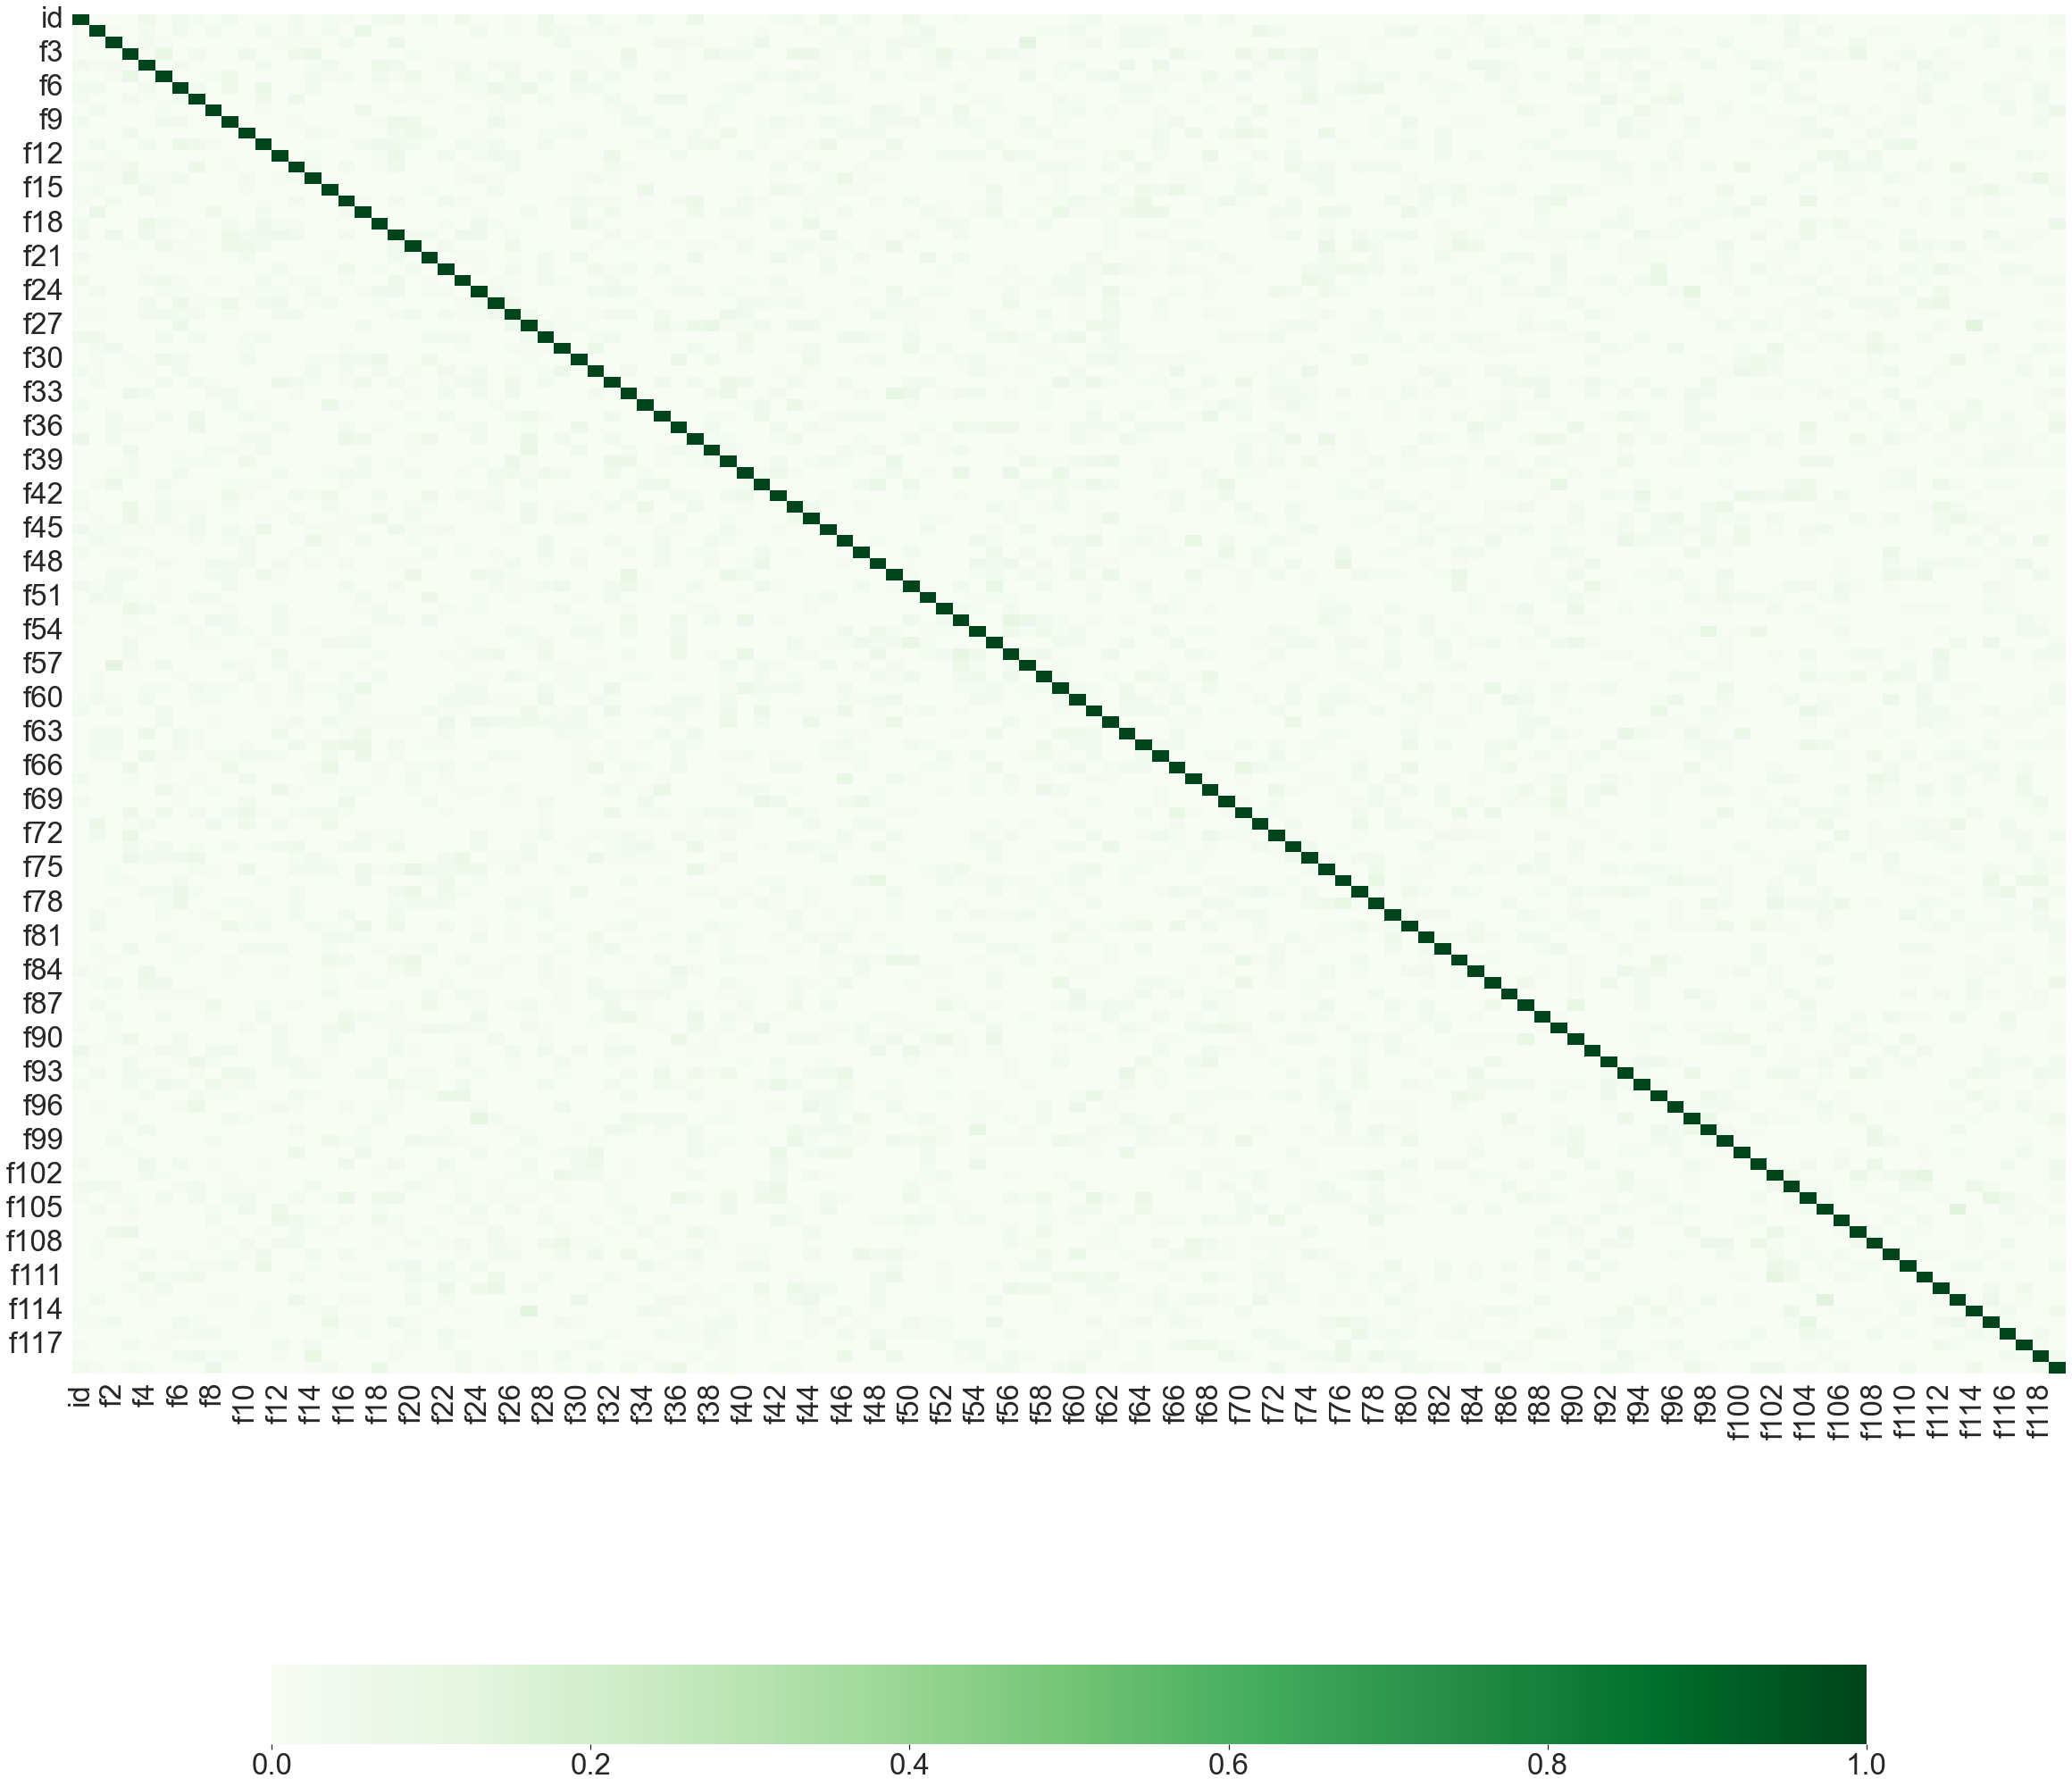

In [26]:
# Matrice di Correlazione
corrMatrix = data_reduced.corr()
plt.figure(figsize = (40, 40))
sn.set(font_scale = 3)
sn.heatmap(corrMatrix, 
           vmin = 0, 
           vmax = 1, 
           cbar_kws = {'orientation': 'horizontal', 'shrink': .8},
           cmap = 'Greens')
plt.show()

## Feature Engineering

In [7]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 128037 to 5940
Columns: 120 entries, id to claim
dtypes: float64(118), int64(2)
memory usage: 945.3 KB


Le colonne presentano tutti valori numerici, non ci sono stringhe. Non è pertanto necessario applicare One Hot Encoding

#### Gestione valori nulli

In [8]:
# Calcolo la percentuale di valori mancanti ordinata in modo decrescente e la trasformo in dataframe
count_missing_value = data_reduced.isna().sum() / data_reduced.shape[0]*100
count_missing_value_df = pd.DataFrame(count_missing_value.sort_values(ascending=False), columns=['Missing%'])
count_missing_value_df.sort_values

<bound method DataFrame.sort_values of        Missing%
f39         2.5
f13         2.5
f19         2.4
f99         2.3
f98         2.3
...         ...
f56         0.8
f92         0.7
f73         0.6
id          0.0
claim       0.0

[120 rows x 1 columns]>

Text(0.5, 0, 'Features')

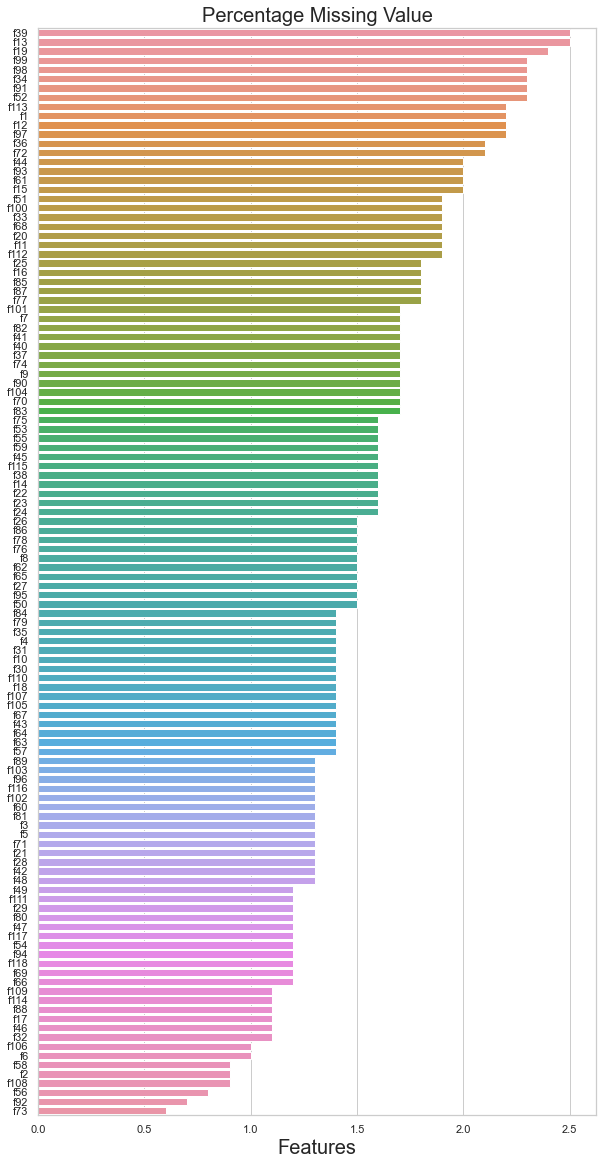

In [9]:
missing_value_df = count_missing_value_df[count_missing_value_df['Missing%'] > 0]

plt.figure(figsize=(10, 20)) # Set the figure size
sn.set_theme(style="whitegrid")
missing_value_graph = sn.barplot(y = missing_value_df.index, x = "Missing%", data=missing_value_df, orient="h")
missing_value_graph.set_title("Percentage Missing Value", fontsize = 20)
missing_value_graph.set_xlabel("Features", fontsize = 20)

In [10]:
# Se eliminassimo i valori nulli?

data_drop = data_reduced.dropna()
data_drop.shape

(373, 120)

In [11]:
# Gestione NaN: sostituzione per ogni colonna del Nan con la sua media

data_fillna = data_reduced.fillna(data_reduced.mean())

In [12]:
data_fillna.isna().sum()

id       0
f1       0
f2       0
f3       0
f4       0
        ..
f115     0
f116     0
f117     0
f118     0
claim    0
Length: 120, dtype: int64

#### Gestione outliers

In [13]:
# Identificazione degli outliers attraverso il metodo del range interquartile (IQR)

Q1 = data_fillna.quantile(0.25)
Q3 = data_fillna.quantile(0.75)

# Definizione regione IQR
IQR = Q3 - Q1
print(IQR)

id       4.592868e+05
f1       4.269800e-02
f2       1.831075e-01
f3       3.798017e+03
f4       2.575357e-01
             ...     
f115     8.730000e-02
f116     5.534516e+16
f117     4.632075e+03
f118     4.565525e-01
claim    1.000000e+00
Length: 120, dtype: float64


In [14]:
# Identifico i due quartili per ogni colonna contenuta nella X, calcolo il limite massimo e il minimo e sostituisco
# tutti i valori al di fuori dei range con un valore nullo

for x in data_fillna.columns.drop(['id', 'claim']):
    q75,q25 = np.percentile(data_fillna.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    data_fillna.loc[data_fillna[x] < min,x] = np.nan
    data_fillna.loc[data_fillna[x] > max,x] = np.nan

In [15]:
data_fillna.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
128037,128037,0.117930,0.003333,3842.800,0.002454,0.437800,-1.85220,261.61,31467.0,3.189700e+15,563.42,1.12090,1.342600e+07,NaN,3.1190,NaN,120.6100,7.3059,1.93450,-0.56327,NaN,136650.00,2.2943,97.889,2.93560,495.960,1.542500e+12,1.399900e+11,1529600.0,-0.003138,6.4238,0.712030,53085.0,55241.000000,0.000494,8.678700e+16,NaN,563.56,1.593400,2613.80,0.001286,1515.9000,0.484630,6.1865,43.083,-0.000155,4.3633,-0.63740,5.0088,-1.20340,-0.002755,17.07400,2735.152789,11.0870,119.87,0.28051,0.065822,-0.000379,-0.21670,5.2748,0.020381,0.269360,5.680400e+08,85.816,0.044977,3828.8,134.540,196.54,32.274,1.1335,0.996490,1.1610,691.230,-5.410300e+12,1.127100e+11,0.079650,7.283600,981.010,4126.00000,5.01690,0.001141,4.033500,1.040500e+11,70.23900,688270.0,1238.800,5.786900e+10,7.7126,295.760,NaN,5.9410,NaN,43.003,82.756,1.0634,14.0280,520.95,1.00280,9.735200e+09,NaN,0.977240,10.2570,805860.0,-51.476,-45.775,0.045825,0.047026,0.044620,3.213900e+08,0.53509,-37.8330,1.3352,-1.5836,-13.88900,16801.0,1.0787,2.269000e+16,2671.900000,0.48396,1
491755,491755,0.093184,0.258100,542.280,-0.002171,0.277570,-1.53880,3298.80,69851.0,8.191000e+13,NaN,0.61400,1.096300e+08,0.299920,13.8910,-0.099310,60.7410,7.3907,0.99344,4.02910,213.780,-886.02,2.3016,94.312,1.22560,189.830,5.487500e+11,4.429000e+12,4718900.0,0.003034,10.7020,1.237900,NaN,15629.000000,-0.001352,6.647100e+16,161.430,658.83,1.754723,141.63,0.918250,1.3897,0.086311,8.3749,23.906,0.004019,4.3673,0.74656,4.4093,-0.49052,0.433460,3.15260,2259.800000,7.0814,133.82,0.37982,0.517000,-0.000107,-0.65149,2.1599,0.845720,0.004519,3.591800e+09,12.808,0.013700,76167.0,90.763,1360.50,11.019,1.1492,0.994780,1.5951,21.232,1.123000e+15,-1.755600e+10,1.014500,7.403300,4499.000,10410.41423,8.74810,0.328540,3.395103,1.391200e+11,4.53590,82455.0,314.670,2.458000e+10,22.4250,9.448,10211.0,5.7530,0.49060,NaN,132.700,1.0449,3.9341,541.46,0.99808,1.690500e+13,1.4038,0.426798,20.8460,4627.3,76.024,-136.740,0.240990,0.066928,-0.000690,2.093200e+09,0.50121,-21.6220,1.5059,8.7256,4.82110,4617.2,1.1703,6.794700e+16,3766.300000,0.67155,1
470924,470924,0.159500,0.475950,1423.100,0.004622,-0.001036,1.20810,657.39,685940.0,1.190000e+14,1281.80,1.41820,3.047900e+09,0.345140,17.4980,-0.102880,86.4300,6.2859,3.02500,1.61160,574.330,-1468.40,1.8014,99.321,-3.14420,34.338,5.991400e+10,-1.809300e+09,37025.0,0.969090,4.9900,0.948000,165180.0,345581.958624,-0.001195,5.322300e+16,13.079,1124.20,1.645400,386.29,0.341182,382.6200,0.014320,7.3817,35.248,-0.004634,4.2119,0.39095,7.4614,-0.80386,0.340350,0.63577,2878.300000,13.7950,129.39,0.34454,0.869150,0.000605,-0.13581,4.7369,0.764510,0.610320,6.304200e+08,NaN,0.032693,1492.9,104.510,304.03,32.613,1.0791,0.993330,1.1423,628.040,NaN,2.703400e+11,0.079255,7.250200,-65.518,11574.00000,0.49632,0.000148,3.395103,2.272900e+11,18.47000,46912.0,89.224,5.026700e+10,1.5367,43.820,5570.0,8.0684,0.50011,1166.300,172.000,1.1898,29.2910,2142.60,0.99838,1.663100e+12,0.9267,0.338970,1.9117,887950.0,-13.908,4261.600,0.286790,0.333750,0.027764,2.002600e+09,0.28972,-5.6433,1.8535,NaN,17.02500,80048.0,NaN,-1.665900e+15,1789.000000,0.53750,0
791624,791624,0.144300,0.486760,5225.700,0.089627,0.428290,-0.98324,2157.70,5992.9,2.240100e+10,7212.90,0.93814,1.350300e+07,0.249419,5.8039,NaN,15.3450,6.8523,5.02870,30.42200,NaN,14443.00,2.1701,94.660,-1.06110,186.410,9.869200e+11,1.153649e+12,1753200.0,0.000332,12.9110,0.008239,35988.0,48215.000000,0.002637,3.632800e+14,NaN,495.19,1.754723,5637.70,0.089411,111.9700,1.003500,6.7952,5.

In [16]:
# Per ogni feature ottengo la percentuale di valori classificati come nulli, ordinata in modo decrescente

outliers_to_nan = data_fillna.isna().sum()/data_fillna.shape[0]*100
outliers_to_nan_df = pd.DataFrame(outliers_to_nan.sort_values(ascending=False), columns=['Outliers to Nan%'])
outliers_to_nan_df

,Outliers to Nan%
f36,16.6
f99,16.1
f112,15.9
f103,15.2
f74,13.8
...,...
f72,0.0
f75,0.0
f81,0.0
f86,0.0


Text(0.5, 0, 'Features')

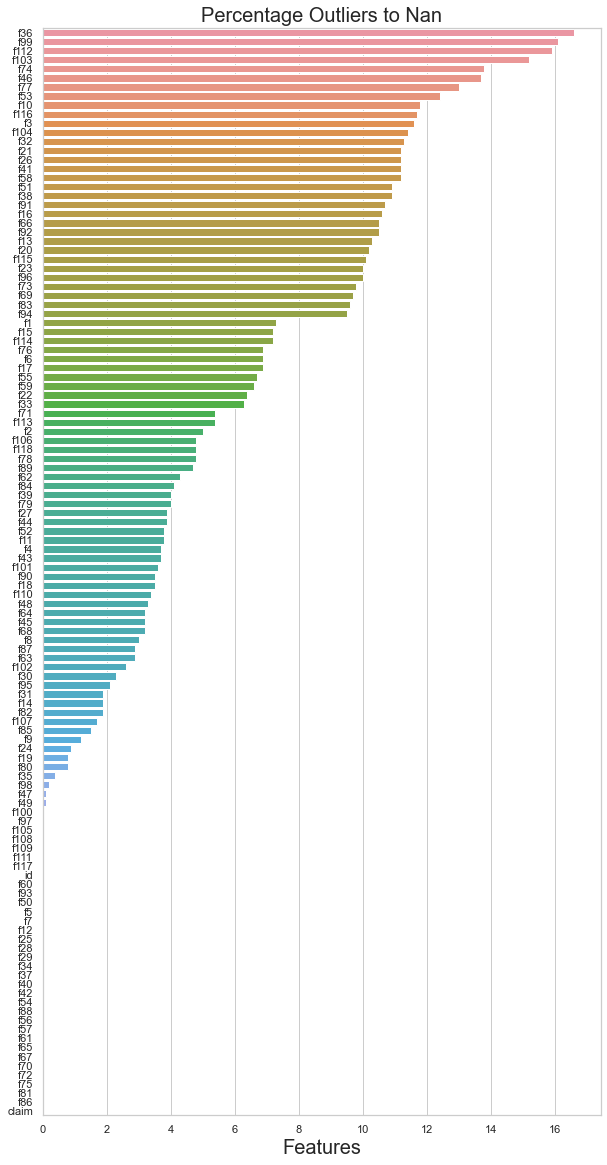

In [17]:
# % outliers_to_nan

plt.figure(figsize=(10, 20)) # Set the figure size
sn.set_theme(style="whitegrid")
outliers_to_nan_graph = sn.barplot(y = outliers_to_nan_df.index, x = 'Outliers to Nan%', data = outliers_to_nan_df, orient="h")
outliers_to_nan_graph.set_title("Percentage Outliers to Nan", fontsize = 20)
outliers_to_nan_graph.set_xlabel("Features", fontsize = 20)

In [18]:
# Controllo che i valori nulli siano stati effettivamente sostituiti con la media

data_outliers_converted = data_fillna.fillna(data_fillna.mean())
data_outliers_converted.isna().sum()

id       0
f1       0
f2       0
f3       0
f4       0
        ..
f115     0
f116     0
f117     0
f118     0
claim    0
Length: 120, dtype: int64

In [19]:
data_outliers_converted.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
128037,128037,0.117930,0.003333,3842.800,0.002454,0.437800,-1.85220,261.61,31467.0,3.189700e+15,563.420000,1.12090,1.342600e+07,0.273593,3.1190,0.012774,120.6100,7.3059,1.93450,-0.56327,132.22838,136650.00,2.2943,97.889,2.93560,495.960,1.542500e+12,1.399900e+11,1529600.0,-0.003138,6.4238,0.712030,53085.000000,55241.000000,0.000494,8.678700e+16,22.61697,563.56,1.593400,2613.80,0.001286,1515.9000,0.484630,6.1865,43.083,-0.000155,4.3633,-0.63740,5.0088,-1.20340,-0.002755,17.07400,2735.152789,11.087000,119.87,0.28051,0.065822,-0.000379,-0.216700,5.2748,0.020381,0.269360,5.680400e+08,85.816000,0.044977,3828.8,134.540,196.54,32.274,1.1335,0.996490,1.1610,691.230,-5.410300e+12,1.127100e+11,0.079650,7.283600,981.010000,4126.00000,5.01690,0.001141,4.033500,1.040500e+11,70.23900,688270.0,1238.800,5.786900e+10,7.7126,295.760,3252.158176,5.9410,0.415443,43.003000,82.756,1.0634,14.0280,520.95,1.00280,9.735200e+09,1.403479,0.977240,10.2570,805860.0,-51.47600,-45.775,0.045825,0.047026,0.044620,3.213900e+08,0.53509,-37.8330,1.3352,-1.583600,-13.88900,16801.0,1.078700,2.269000e+16,2671.900000,0.483960,1
491755,491755,0.093184,0.258100,542.280,-0.002171,0.277570,-1.53880,3298.80,69851.0,8.191000e+13,2116.533339,0.61400,1.096300e+08,0.299920,13.8910,-0.099310,60.7410,7.3907,0.99344,4.02910,213.78000,-886.02,2.3016,94.312,1.22560,189.830,5.487500e+11,4.429000e+12,4718900.0,0.003034,10.7020,1.237900,72849.037143,15629.000000,-0.001352,6.647100e+16,161.43000,658.83,1.754723,141.63,0.918250,1.3897,0.086311,8.3749,23.906,0.004019,4.3673,0.74656,4.4093,-0.49052,0.433460,3.15260,2259.800000,7.081400,133.82,0.37982,0.517000,-0.000107,-0.651490,2.1599,0.845720,0.004519,3.591800e+09,12.808000,0.013700,76167.0,90.763,1360.50,11.019,1.1492,0.994780,1.5951,21.232,1.123000e+15,-1.755600e+10,1.014500,7.403300,4499.000000,10410.41423,8.74810,0.328540,3.395103,1.391200e+11,4.53590,82455.0,314.670,2.458000e+10,22.4250,9.448,10211.000000,5.7530,0.490600,2359.800717,132.700,1.0449,3.9341,541.46,0.99808,1.690500e+13,1.403800,0.426798,20.8460,4627.3,76.02400,-136.740,0.240990,0.066928,-0.000690,2.093200e+09,0.50121,-21.6220,1.5059,8.725600,4.82110,4617.2,1.170300,6.794700e+16,3766.300000,0.671550,1
470924,470924,0.159500,0.475950,1423.100,0.004622,-0.001036,1.20810,657.39,685940.0,1.190000e+14,1281.800000,1.41820,3.047900e+09,0.345140,17.4980,-0.102880,86.4300,6.2859,3.02500,1.61160,574.33000,-1468.40,1.8014,99.321,-3.14420,34.338,5.991400e+10,-1.809300e+09,37025.0,0.969090,4.9900,0.948000,165180.000000,345581.958624,-0.001195,5.322300e+16,13.07900,1124.20,1.645400,386.29,0.341182,382.6200,0.014320,7.3817,35.248,-0.004634,4.2119,0.39095,7.4614,-0.80386,0.340350,0.63577,2878.300000,13.795000,129.39,0.34454,0.869150,0.000605,-0.135810,4.7369,0.764510,0.610320,6.304200e+08,36.125457,0.032693,1492.9,104.510,304.03,32.613,1.0791,0.993330,1.1423,628.040,4.498874e+14,2.703400e+11,0.079255,7.250200,-65.518000,11574.00000,0.49632,0.000148,3.395103,2.272900e+11,18.47000,46912.0,89.224,5.026700e+10,1.5367,43.820,5570.000000,8.0684,0.500110,1166.300000,172.000,1.1898,29.2910,2142.60,0.99838,1.663100e+12,0.926700,0.338970,1.9117,887950.0,-13.90800,4261.600,0.286790,0.333750,0.027764,2.002600e+09,0.28972,-5.6433,1.8535,3.718446,17.02500,80048.0,1.182004,-1.665900e+15,1789.000000,0.537500,0
791624,791624,0.144300,0.486760,5225.700,0.089627,0.428290,-0.98324,2157.70,5992.9,2.240100e+10,7212.900000,0.93814,1.350300e+07,0.249419,5.8039,0.012774,15.3450,6.8523,5.02870,30.42200,132.22838,14443.00,2.1701,

In [20]:
data_outliers_converted.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,482414.435000,0.094988,0.361018,1912.649826,0.177550,0.313383,-0.192052,1671.669964,3.282851e+05,1.746954e+15,2116.533339,0.699299,1.765465e+09,0.273593,6.453979,0.012774,277.738017,6.751849,3.940257,22.138509,132.228380,32868.195874,2.304086,97.600885,0.273237,425.808116,1.533494e+12,1.000384e+12,2.327502e+06,0.347528,7.342467,0.437656,72849.037143,2.651706e+05,-0.000063,2.848411e+16,22.616970,417.984344,1.584299,1692.331865,0.341182,269.777471,0.364981,6.876420,26.659013,0.011657,4.331803,0.023406,6.185185,-0.430003,0.305341,29.570025,2427.155082,5.450905,137.892986,0.268202,0.397768,-0.000107,-0.250712,2.721689,0.540806,0.279254,2.040689e+09,36.125457,0.179676,46472.505569,95.224938,593.395302,26.035357,1.182220,0.419261,1.488114,501.300342,4.498874e+14,2.389218e+11,0.385802,6.772105,6470.470346,9049.254443,0.758689,0.185045,3.395103,9.975464e+10,74.801574,4.970615e+06,609.364835,3.176813e+10,23.544168,204.927743,3252.158176,6.397769,0.415443,2359.800717,132.141635,0.997120,12.686666,2246.082512,0.999954,1.416355e+13,1.403479,0.426798,17.440543,2.904808e+05,220.938220,1782.217970,0.183996,0.130452,0.012271,1.708876e+09,0.392083,-18.667298,2.110420,3.718446,0.827121,43177.482525,1.182004,2.244285e+16,3974.641823,0.487534,0.511000
std,274749.994498,0.032458,0.122116,2145.641414,0.162472,0.141418,1.252299,1308.947445,2.781141e+05,2.137260e+15,2805.131892,1.272114,2.071421e+09,0.057226,5.717495,0.066949,387.053130,1.033820,3.092549,13.925835,176.412497,39954.540172,0.555000,22.553320,1.603942,314.602367,1.838264e+12,1.373480e+12,2.352313e+06,0.438132,4.925964,0.697567,92740.980735,2.813645e+05,0.001537,3.363399e+16,169.640429,311.751204,0.297458,1478.972190,0.433458,338.739778,0.404114,1.292826,23.465957,0.011938,0.444644,0.669502,1.758720,0.719217,0.143131,38.257015,1997.377503,7.925987,16.048374,0.086942,0.319251,0.001487,0.157343,1.325337,0.271029,0.255707,2.160227e+09,29.884110,0.171791,35657.418588,20.127046,514.255815,21.938831,0.071944,0.489264,0.321096,376.832806,5.791311e+14,3.634158e+11,0.443059

In [21]:
# Definisco le variabili

X = data_outliers_converted.drop(['id', 'claim'], axis = 1)
y = data_outliers_converted['claim']

array([[<AxesSubplot:title={'center':'f1'}>,
        <AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'f3'}>,
        <AxesSubplot:title={'center':'f4'}>,
        <AxesSubplot:title={'center':'f5'}>,
        <AxesSubplot:title={'center':'f6'}>,
        <AxesSubplot:title={'center':'f7'}>,
        <AxesSubplot:title={'center':'f8'}>,
        <AxesSubplot:title={'center':'f9'}>,
        <AxesSubplot:title={'center':'f10'}>,
        <AxesSubplot:title={'center':'f11'}>],
       [<AxesSubplot:title={'center':'f12'}>,
        <AxesSubplot:title={'center':'f13'}>,
        <AxesSubplot:title={'center':'f14'}>,
        <AxesSubplot:title={'center':'f15'}>,
        <AxesSubplot:title={'center':'f16'}>,
        <AxesSubplot:title={'center':'f17'}>,
        <AxesSubplot:title={'center':'f18'}>,
        <AxesSubplot:title={'center':'f19'}>,
        <AxesSubplot:title={'center':'f20'}>,
        <AxesSubplot:title={'center':'f21'}>,
        <AxesSubplot:title={'center':'f22'

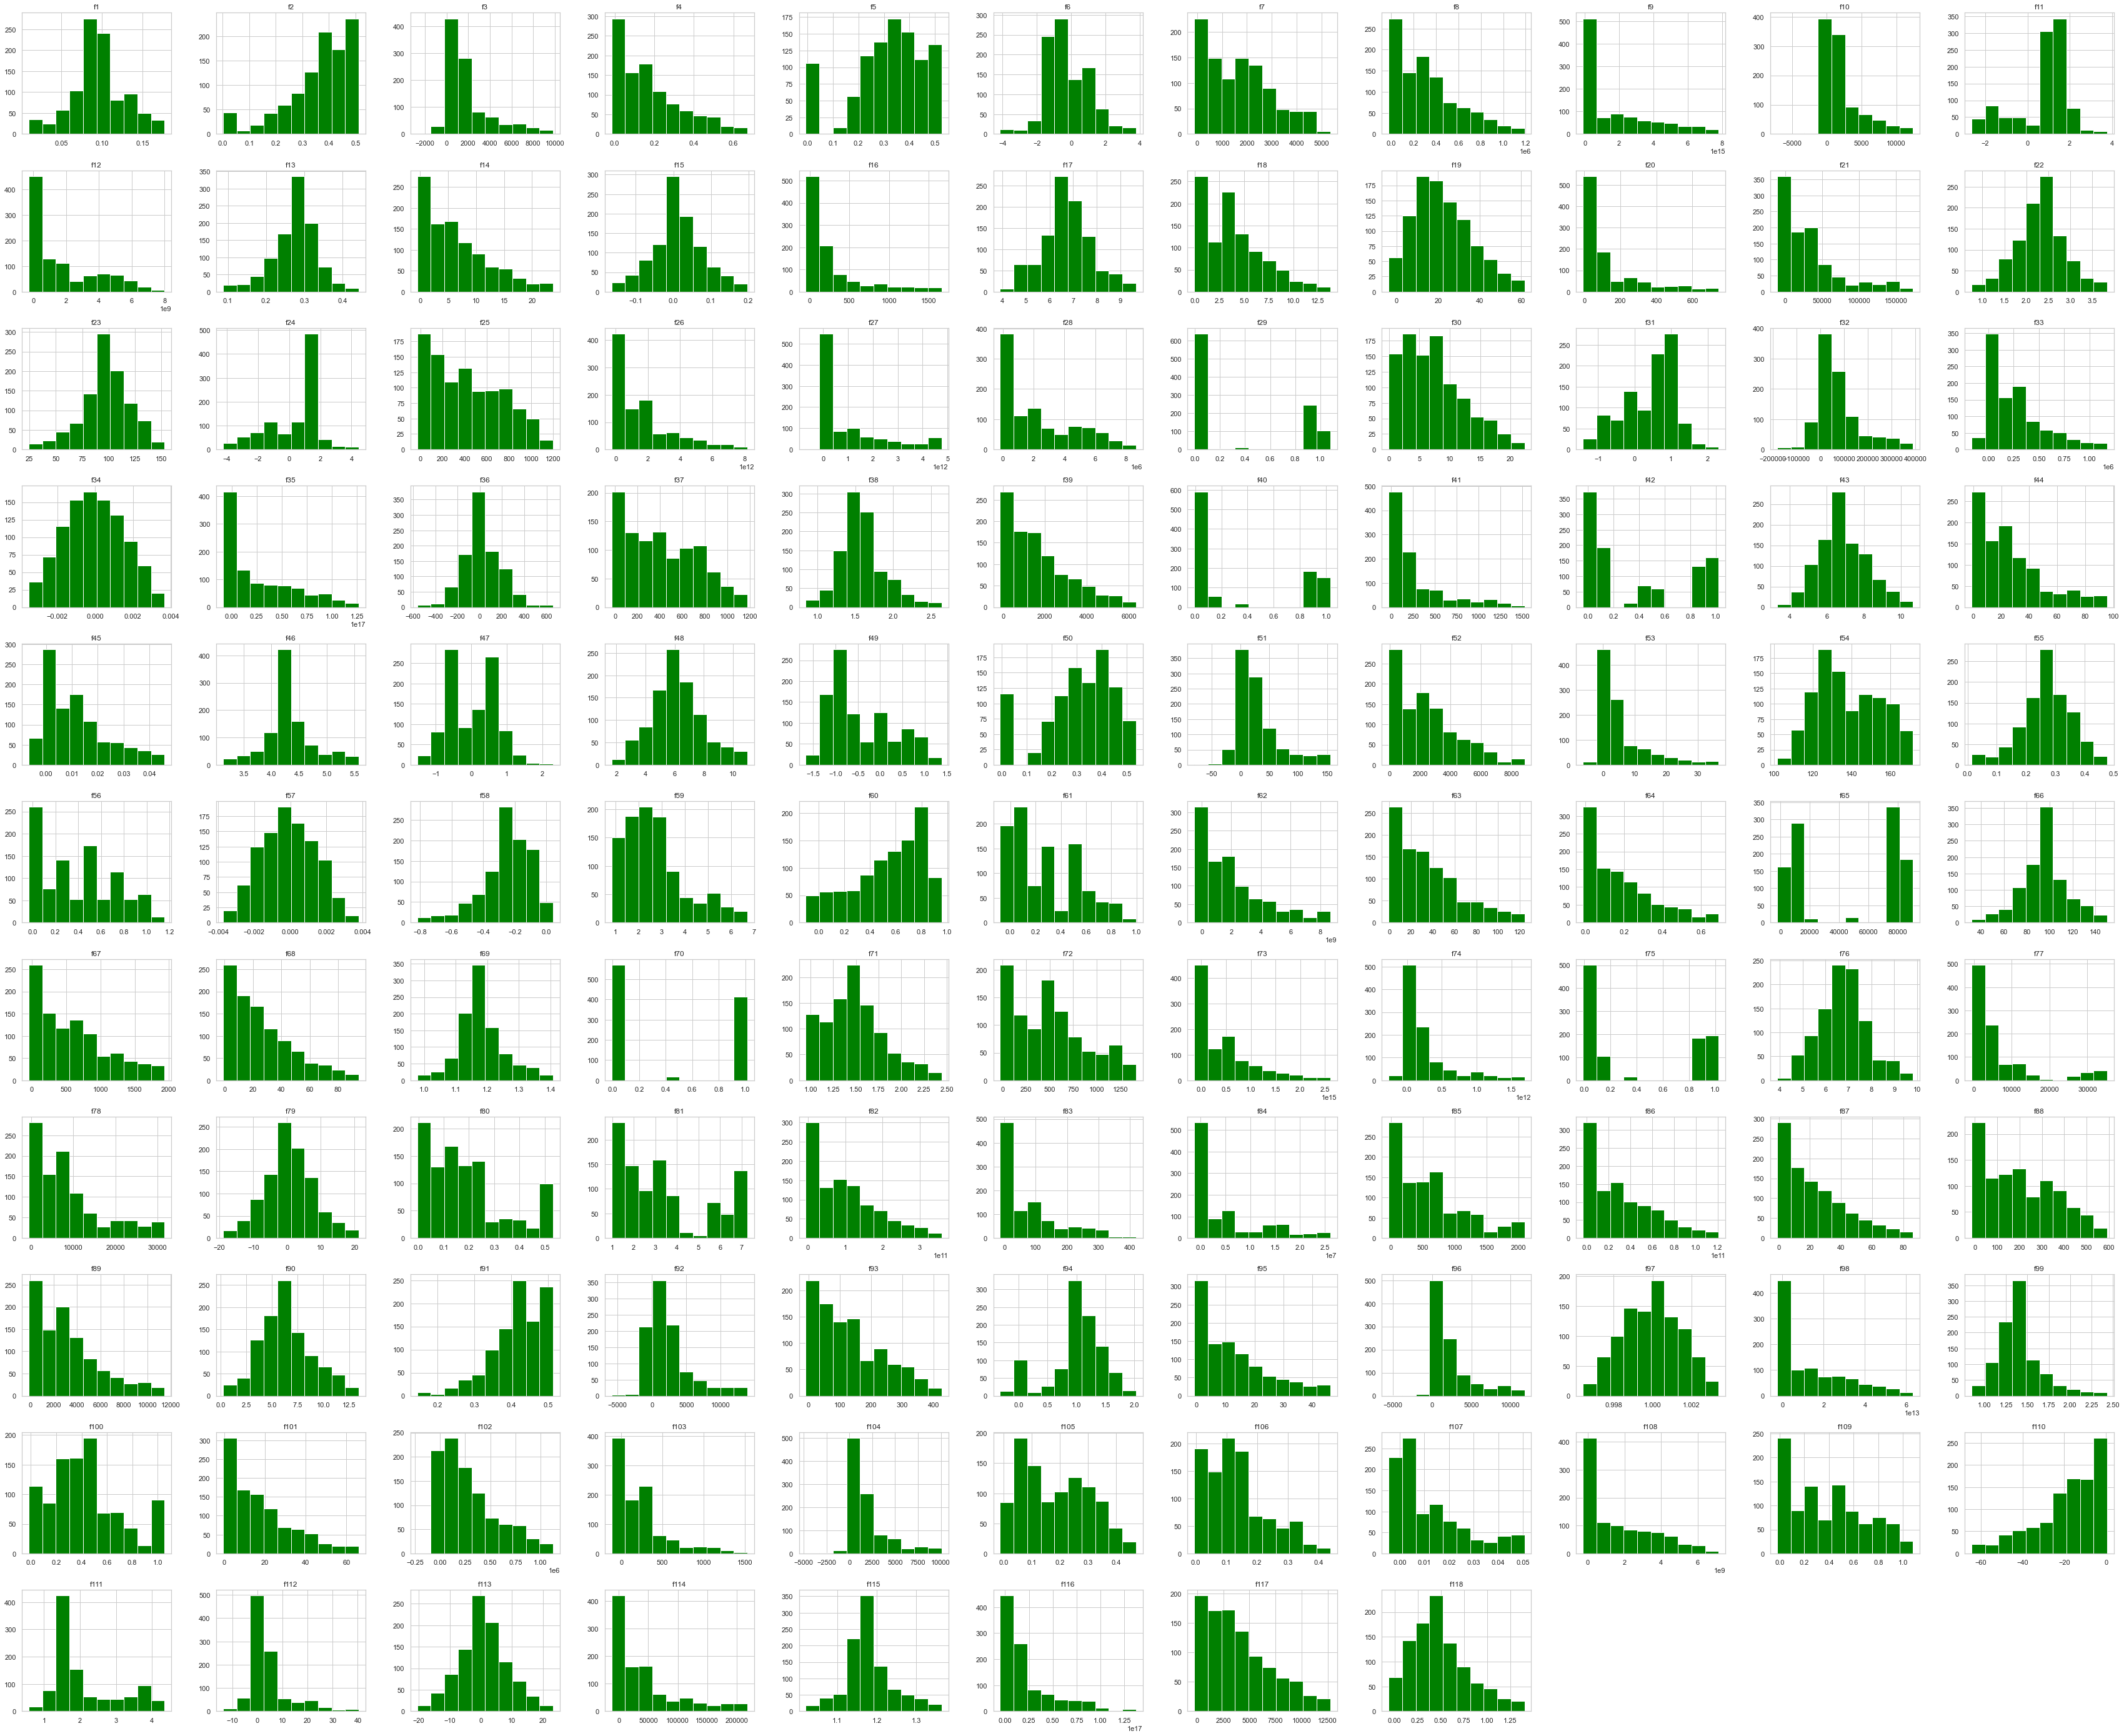

In [22]:
X.hist(figsize = (60, 50),
      color = 'green')

In [23]:
# Percentuali di frequenza dei valori 0 e 1

y.value_counts(normalize = True)*100

1    51.1
0    48.9
Name: claim, dtype: float64

I valori della colonna claim risultano bilanciati, non c'è bisogno di applicare Oversampling/Undersampling/SMOTE

## Pipeline

### Decision Tree

In [25]:
grid = { 
    'rfe__n_features_to_select': [None, 5, 10],
    'rfe__step': [1, 3, 5],
    'dt__max_depth': [None, 3, 5, 10]
}

pipeline_dt = Pipeline([
    ('minmax', MinMaxScaler()),
    ('rfe', RFE(estimator = DecisionTreeClassifier())),
    ('dt', DecisionTreeClassifier())
])

gscv = GridSearchCV(estimator = pipeline_dt, param_grid = grid, scoring = 'roc_auc')
cv = cross_validate(gscv, X = X, y = y, scoring ='roc_auc', cv = 3) #cross validation - outer loop
score = np.mean(cv['test_score']) # calcolo dello score in termini di roc_auc
score # score medio

0.5445161281245537

### Random Forest

In [27]:
grid = {
    'rf__max_depth': [None, 2, 5],
    'rf__random_state': [None, 1, 2]
}

pipeline_rf = Pipeline([
    ('minmax', MinMaxScaler()),
    #('fs', SelectKBest(chi2)),
    ('rf', RandomForestClassifier())
])

gscv = GridSearchCV(estimator = pipeline_rf, param_grid = grid, scoring = 'roc_auc')
cv = cross_validate(gscv, X = X, y = y, scoring ='roc_auc', cv = 3) #cross validation - outer loop
score = np.mean(cv['test_score']) # calcolo dello score in termini di roc_auc
score # score medio

0.5533692384857649

### Logistic Regression

In [45]:
grid = { 
    #'fs__k': [5]
    #'rfe__n_features_to_select': [None]
}

pipeline_lr = Pipeline([
    ('minmax', MinMaxScaler()),
    #('rfe', RFE(estimator = LogisticRegression())),
    #('fs', SelectKBest(chi2, k = 2)),
    ('lr', LogisticRegression())
])

gscv = GridSearchCV(estimator = pipeline_rf, param_grid = grid, scoring = 'accuracy')
cv = cross_validate(gscv, X = X, y = y, scoring ='accuracy', cv = 10) #cross validation - outer loop
score = np.mean(cv['test_score']) # calcolo dello score in termini di accuracy
score # score medio

0.5549999999999999

In [31]:
class Giudice():
    
    def __init__(self):
        return None
        
    def data(self, X, y):
        self.X = X
        self.y = y
        return None
    
    def algo(self, algo):
        self.algo = algo
        return None
    
    def params(self, params):
        self.params = params
        return None
    
    def metrics(self, metrics):
        self.metrics = metrics
        return None
        
    def scores(self, metrics, algo, params):
        cv_Kfold = KFold(n_splits=10, random_state=1, shuffle=True)
        gscv = GridSearchCV(estimator = algo, param_grid = params, cv = cv_Kfold)
        scores = cross_validate(gscv, X = self.X, y = self.y, cv = cv_Kfold, scoring = metrics)
        score = np.mean(scores['test_score'])
        score = round(score, 2)
        return score
        
    def get_table(self, algo, metrics, params):
        metrics_results = {}
        for metrics in self.metrics:
            algo_results = {} 
            for label, algo in self.algo.items():
                grid = {}
                if label in self.params.keys():
                    grid = self.params[label]
                algo_results [label] = self.scores(metrics, algo, grid)
            metrics_results[metrics] = algo_results
            
            df = pd.DataFrame.from_dict(metrics_results)
        
        return df

## Model Evaluation and selection

In [32]:
pipelines = {
    'pipe_dt': pipeline_dt,
    'pipe_rf': pipeline_rf,
    'pipe_lr': pipeline_lr,
}

# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
metrics = [
    'roc_auc', 
    'accuracy',
    'precision'
]

params = {
    'dt': {
        'dt__max_depth': [None, 2, 3]
    },
    'rf': {
        'rf__n_estimators': [10, 50],
    },
    'lr':{
        'lr__max_iter': [10, 20, 50],
    }
}

giudice = Giudice()
giudice.data(X, y)
giudice.algo(pipelines)
giudice.params(params)
giudice.metrics(metrics)
giudice.get_table(pipelines, metrics, params)

,roc_auc,accuracy,precision
pipe_dt,0.51,0.50,0.51
pipe_rf,0.58,0.55,0.55
pipe_lr,0.55,0.54,0.55


## Model Evaluation and selection

In [36]:
best_pipe = pipeline_lr
clf = GridSearchCV(best_pipe, param_grid = {})
clf.fit(X, y)
clf.best_estimator_

Pipeline(steps=[('minmax', MinMaxScaler()), ('lr', LogisticRegression())])

In [37]:
clf.score(X, y)

0.659